In [1]:
import numpy as np
import torch
from tifffile import imread, imsave
import sys
sys.path.append('../')
from HDN.models.lvae import LadderVAE
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load trained denoiser

In [3]:
denoiser_location = '../dn_checkpoint/conv/final_params.ckpt'
vae = LadderVAE.load_from_checkpoint(denoiser_location).to(device).eval()

/home/ben/miniconda3/envs/pl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'noiseModel' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['noiseModel'])`.
  rank_zero_warn(


Load noisy images and ground truth

In [4]:
data_directory = '../data/conv'
observation = imread(os.path.join(data_directory, 'observation.tif'))
signal = imread(os.path.join(data_directory, 'signal.tif'))

Create prediction function

In [5]:
def predict(dn, observation):
    '''
    Passes images through network, returns samples from posterior and MMSE.
    Parameters
    ----------
    dn: LightningModule
        Trained denoiser network.
    observation: numpy array
        Noisy images.
    '''
    
    # Check observation has colour channel
    if observation.ndim == 3:
        observation = observation[:, np.newaxis]
    
    # Convert observation to pytorch tensor and normalise
    observation = torch.from_numpy(observation).to(device).float()
    observation = (observation - dn.data_mean) / dn.data_std
    
    # Create empty mmse and sample arrays
    mmse = torch.zeros_like(observation)
    samples = torch.zeros((observation.shape[0], 100, observation.shape[1], observation.shape[2], observation.shape[3]))
        
    # Extract an image and repeat it 100 times along its first axis
    # Pass these through the network in 5 batches of 20.
    # Calculate mean of samples and insert into mmse array
    for i in tqdm(range(observation.shape[0])):
        single_image = observation[i:i+1]
        single_image = torch.repeat_interleave(single_image, 100, axis=0)
        
        for j in range(20):
            samples[i, j*5:(j+1)*5] = dn(single_image[j*5:(j+1)*5])['out_mean'].detach()
            
    samples = samples * dn.data_std + dn.data_mean
    samples = samples.cpu().numpy()
    mmse = np.mean(samples, axis=1)
    
    return samples, mmse

Create PSNR function

In [6]:
def PSNR(gt, img, psnrRange):
    '''
    Compute PSNR.
    Parameters
    ----------
    gt: array
        Ground truth image.
    img: array
        Predicted image.
    psnrRange: float
        Range PSNR
    '''
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(psnrRange) - 10 * np.log10(mse)

Evaluate

In [7]:
samples, mmse = predict(vae, observation)

100%|████████████████████████████████████████████████████████████████████████████████████████| 64/64 [01:58<00:00,  1.85s/it]


Compare visually to signal

Text(0.5, 1.0, 'Sample')

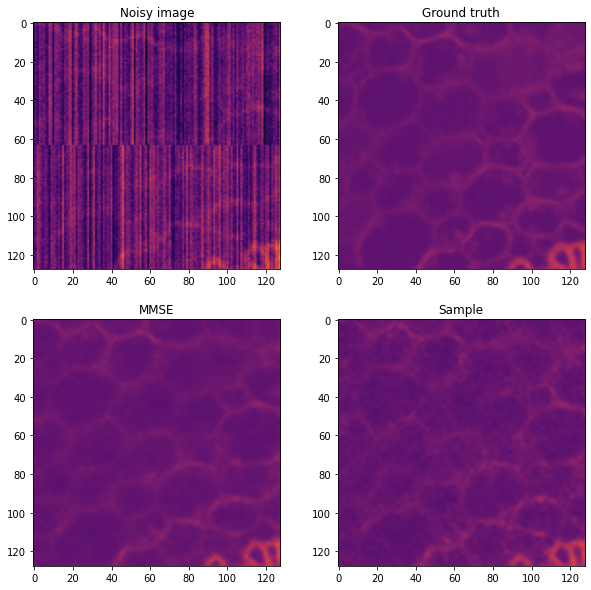

In [8]:
idx = np.random.randint(mmse.shape[0])
sample_idx = np.random.randint(100)

vmin = np.percentile(observation, 0.1)
vmax = np.percentile(observation, 99.9)

fig, ax = plt.subplots(2, 2, figsize=[10, 10])
ax[0, 0].imshow(observation[idx], vmin=vmin, vmax=vmax, cmap='inferno')
ax[0, 0].set_title('Noisy image')
ax[0, 1].imshow(signal[idx], vmin=vmin, vmax=vmax, cmap='inferno')
ax[0, 1].set_title('Ground truth')
ax[1, 0].imshow(mmse[idx, 0], vmin=vmin, vmax=vmax, cmap='inferno')
ax[1, 0].set_title('MMSE')
ax[1, 1].imshow(samples[idx, sample_idx, 0], vmin=vmin, vmax=vmax, cmap='inferno')
ax[1, 1].set_title('Sample')

Compute PSNR

In [9]:
psnrs = []

for i in range(mmse.shape[0]):
    range_psnr = np.max(signal[i]) - np.min(signal[i])
    psnrs.append(PSNR(signal[i], mmse[i, 0], range_psnr))

print(np.mean(psnrs))

26.494394862346628


Save results

In [10]:
results_directory = '../results/conv'
if not os.path.exists(results_directory):
    os.makedirs(results_directory)
imsave(os.path.join(results_directory, 'mmse.tif'), mmse)
imsave(os.path.join(results_directory, 'samples.tif'), samples)